In [448]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [449]:
# Load merged player data (fm_inside + official_info)
with open('/Users/jooyong/github_locals/Premier_League_match_prediction/merge_pre_process_player_data/merged_player_data.json') as f:
  merged_data = json.load(f)

In [450]:
# Count how many field player or goal keeper there are.
# There are some players that position is not defined.

count_field = 0
count_keeper = 0

unspecified_position_player = []

for i in merged_data.keys():
    
    if 'position' in list(merged_data[i]['entity']['info'].keys()):
        
        if merged_data[i]['entity']['info']['position']!='G':
            count_field+=1
            
        else:
            count_keeper+=1
            
    else:
            unspecified_position_player.append(i)


In [451]:
print('The number of players whose position is not defined:', len(merged_data) - (count_field + count_keeper))
print('The number of field players:', count_field)
print('The number of goal keepers:', count_keeper)

The number of players whose position is not defined: 3
The number of field players: 3139
The number of goal keepers: 268


In [452]:
print('key of unspecified position players...\n')
for i in unspecified_position_player:
    print('id:',i)

key of unspecified position players...

id: 187
id: 246
id: 2367


In [453]:
def get_player_attributes(given_data, field_or_keeper):
    player_attributes = []

    for player_id, data in given_data.items():
        if 'position' in data['entity']['info']:

            if field_or_keeper == 'field' and data['entity']['info']['position'] != 'G':
                player_attributes.extend(data['official_stats'].keys())

            if field_or_keeper == 'keeper' and data['entity']['info']['position'] == 'G':
                player_attributes.extend(data['official_stats'].keys())

    return player_attributes



def get_percentage_of_players_with_attributes(given_data, attributes, total_players, field_or_keeper):
    percentage_dict = {}
    
    for p in range(100):
        total_matches = 0
        top_attributes = attributes[:p]
        
        for player_id, data in given_data.items():
            if 'position' in data['entity']['info']:
                if field_or_keeper == 'field' and data['entity']['info']['position'] != 'G':
                    count = sum(1 for att in top_attributes if att in data['official_stats'])
                    if count == p:
                        total_matches += 1

                if field_or_keeper == 'keeper' and data['entity']['info']['position'] == 'G':
                    count = sum(1 for att in top_attributes if att in data['official_stats'])
                    if count == p:
                        total_matches += 1

        percentage_dict[p] = total_matches / total_players

    return percentage_dict



def get_players_without_selected_attributes(given_data, attributes, field_or_keeper, num_top_atts):
    players_without_selected_atts = []
    top_attributes_count = num_top_atts
    top_attributes = attributes[:top_attributes_count]

    for player_id, data in given_data.items():
        if 'position' in data['entity']['info']:
            if field_or_keeper == 'field' and data['entity']['info']['position'] != 'G':
                count = sum(1 for att in top_attributes if att in data['official_stats'])
                if count != top_attributes_count:
                    players_without_selected_atts.append(player_id)

            if field_or_keeper == 'keeper' and data['entity']['info']['position'] == 'G':
                count = sum(1 for att in top_attributes if att in data['official_stats'])
                if count != top_attributes_count:
                    players_without_selected_atts.append(player_id)

    return players_without_selected_atts



def most_att(data, field_or_keeper):
    attributes = get_player_attributes(data, field_or_keeper)
    value, counts = np.unique(attributes, return_counts=True)
    players_atts_in_order = sorted(zip(value, counts), key=lambda x: x[1], reverse=True)
    return players_atts_in_order



def percent_players_has_selected_atts(data, field_or_keeper):
    ordered_attributes = list(map(lambda x: x[0], most_att(data, field_or_keeper)))

    if field_or_keeper == 'field':
        total_players = sum(1 for player_id in data if 'position' in data[player_id]['entity']['info'] and data[player_id]['entity']['info']['position']!='G')
    elif field_or_keeper == 'keeper':
        total_players = sum(1 for player_id in data if 'position' in data[player_id]['entity']['info'] and data[player_id]['entity']['info']['position']=='G')

    
    return get_percentage_of_players_with_attributes(data, ordered_attributes, total_players, field_or_keeper)



def player_dont_have_selec_atts(data, field_or_keeper, num_top_atts):
    ordered_attributes = list(map(lambda x: x[0], most_att(data, field_or_keeper)))
    return get_players_without_selected_attributes(data, ordered_attributes, field_or_keeper, num_top_atts)

In [454]:
most_att(merged_data, 'field')[:10]

[('appearances', 3130),
 ('losses', 3083),
 ('wins', 3026),
 ('draws', 3008),
 ('clean_sheet', 2720),
 ('yellow_card', 2711),
 ('goal_assist', 2345),
 ('goals', 2319),
 ('mins_played', 2266),
 ('attempts_conceded_ibox', 2251)]

In [455]:
most_att(merged_data, 'keeper')[:10]

[('appearances', 268),
 ('losses', 258),
 ('draws', 247),
 ('wins', 242),
 ('clean_sheet', 240),
 ('mins_played', 191),
 ('attempts_conceded_ibox', 190),
 ('game_started', 190),
 ('accurate_back_zone_pass', 189),
 ('accurate_pass', 189)]

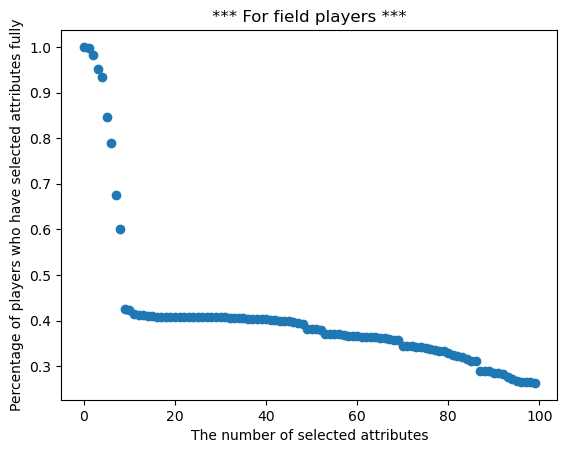

In [456]:
temp = percent_players_has_selected_atts(merged_data, 'field')
x_values = list(temp.keys())
y_values = list(temp.values())
plt.scatter(x_values, y_values)
plt.title('*** For field players ***')
plt.xlabel('The number of selected attributes')
plt.ylabel('Percentage of players who have selected attributes fully')
plt.show()

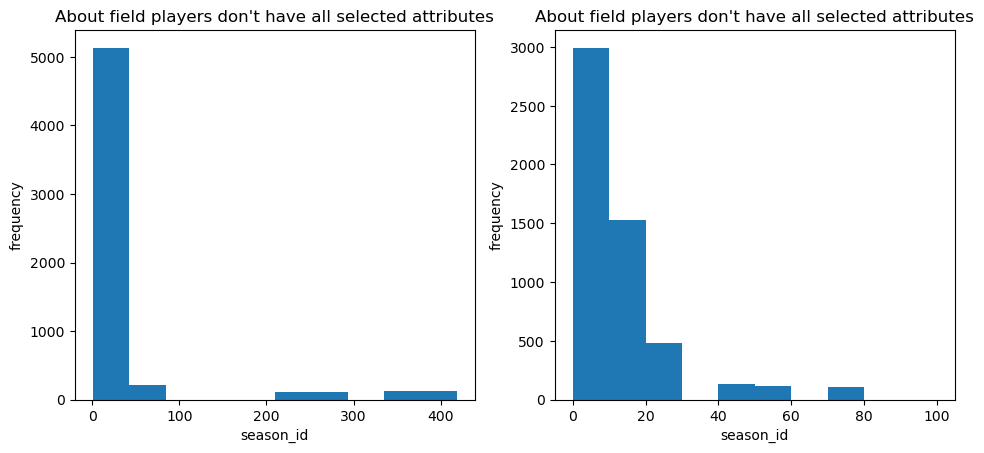

In [457]:
temp = player_dont_have_selec_atts(merged_data, 'field', 40)

temp_list = []

for i in temp:
    for k in merged_data[i]['seasons']:
            temp_list.append(int(k))


plt.subplot(121)
plt.hist(temp_list)
plt.title("About field players don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(temp_list, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("About field players don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplots_adjust(right=1.5)

plt.show()

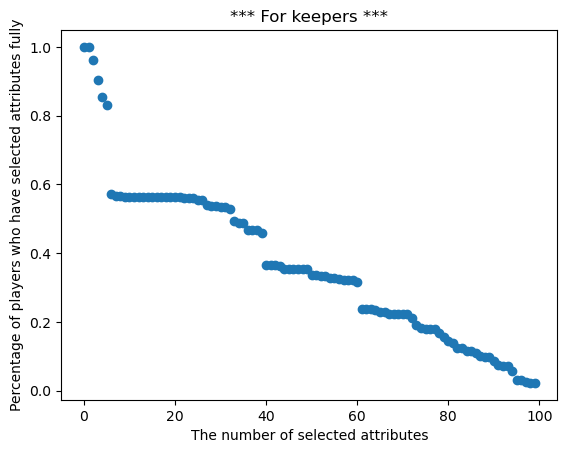

In [458]:
temp = percent_players_has_selected_atts(merged_data, 'keeper')
x_values = list(temp.keys())
y_values = list(temp.values())
plt.scatter(x_values, y_values)
plt.title('*** For keepers ***')
plt.xlabel('The number of selected attributes')
plt.ylabel('Percentage of players who have selected attributes fully')
plt.show()

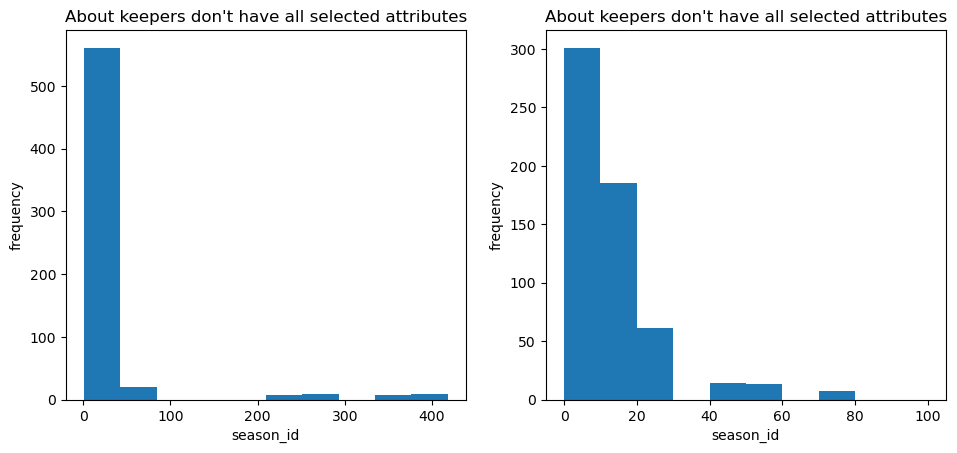

In [459]:
temp = player_dont_have_selec_atts(merged_data, 'keeper', 40)

temp_list = []

for i in temp:
    for k in merged_data[i]['seasons']:
            temp_list.append(int(k))


plt.subplot(121)
plt.hist(temp_list)
plt.title("About keepers don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(temp_list, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("About keepers don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplots_adjust(right=1.5)

plt.show()

In [460]:
list_merged_data = []

for key, value in merged_data.items():

    list_merged_data.append({key:value})


In [461]:
# 2015-16 seaon id is 42.
filtered_merged_data = list(filter(lambda x: len(set(list(x.values())[0]['seasons'])&set(map(lambda x: str(x), range(40))))==0, list_merged_data))

In [462]:
len(filtered_merged_data)

909

In [463]:
with open('test.json', "w") as json_file:
    # Iterate over each dictionary in the list
    for item in filtered_merged_data:
        # Convert the dictionary to a JSON string
        json_string = json.dumps(item)
        # Write the JSON string to the file followed by a newline character
        json_file.write(json_string + "\n")

In [464]:
file_path = '/Users/jooyong/github_locals/Premier_League_match_prediction/Analysis/test.json'

data_dict = {}

with open(file_path, "r") as json_file:
    # Read each line of the file
    for line in json_file:
        # Parse the JSON object from the line and append it to the list
        data = json.loads(line)
        data_dict[list(data.keys())[0]] = list(data.values())[0]

In [465]:
# Count how many field player or goal keeper there are.
# There are some players that position is not defined.

count_field = 0
count_keeper = 0

unspecified_position_player = []

for i in data_dict.keys():
    
    if 'position' in list(data_dict[i]['entity']['info'].keys()):
        
        if data_dict[i]['entity']['info']['position']!='G':
            count_field+=1
            
        else:
            count_keeper+=1
            
    else:
            unspecified_position_player.append(i)


In [466]:
count_field

847

In [467]:
count_keeper

62

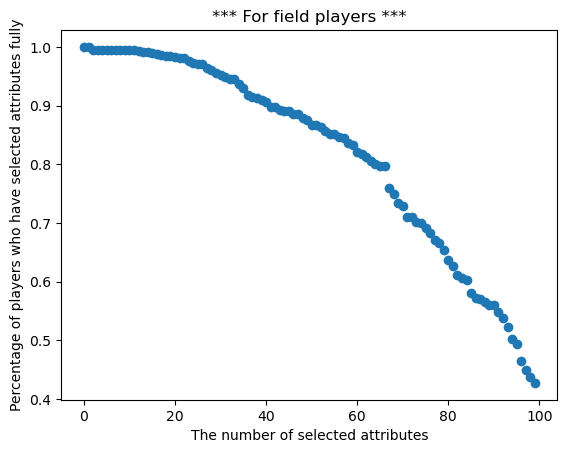

In [468]:
temp = percent_players_has_selected_atts(data_dict, 'field')
x_values = list(temp.keys())
y_values = list(temp.values())
plt.scatter(x_values, y_values)
plt.title('*** For field players ***')
plt.xlabel('The number of selected attributes')
plt.ylabel('Percentage of players who have selected attributes fully')
plt.show()

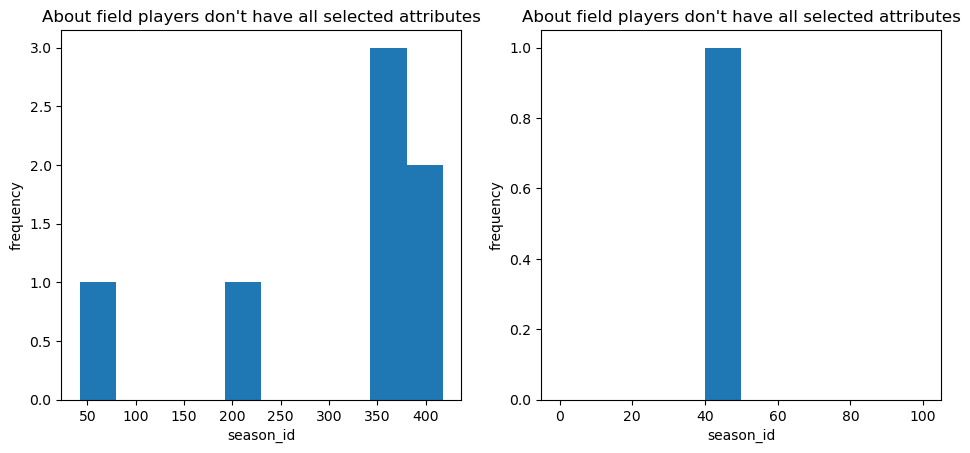

In [469]:
temp = player_dont_have_selec_atts(data_dict, 'field', 20)

temp_list = []

for i in temp:
    for k in data_dict[i]['seasons']:
            temp_list.append(int(k))


plt.subplot(121)
plt.hist(temp_list)
plt.title("About field players don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(temp_list, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("About field players don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplots_adjust(right=1.5)

plt.show()

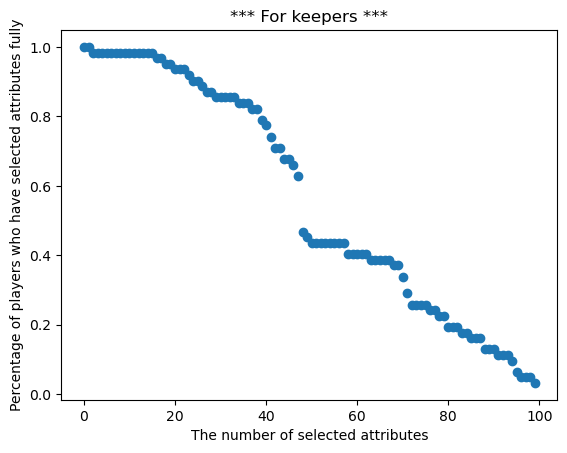

In [470]:
temp = percent_players_has_selected_atts(data_dict, 'keeper')
x_values = list(temp.keys())
y_values = list(temp.values())
plt.scatter(x_values, y_values)
plt.title('*** For keepers ***')
plt.xlabel('The number of selected attributes')
plt.ylabel('Percentage of players who have selected attributes fully')
plt.show()

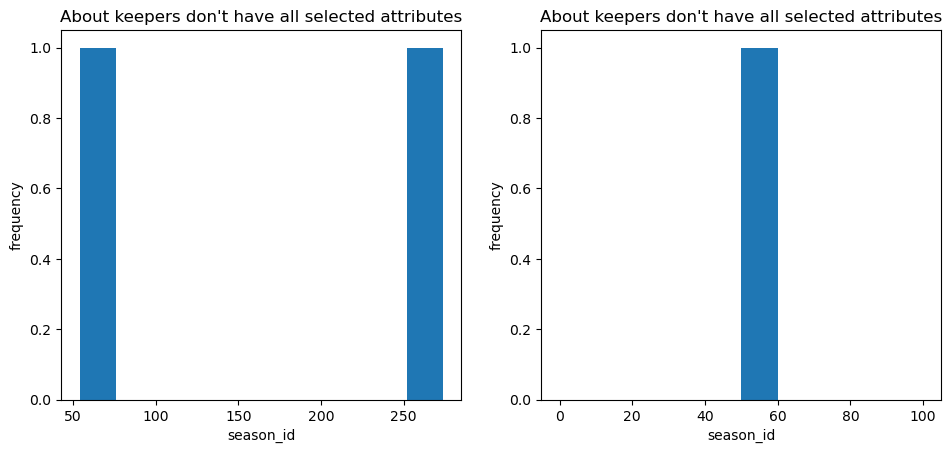

In [471]:
temp = player_dont_have_selec_atts(data_dict, 'keeper', 20)

temp_list = []

for i in temp:
    for k in data_dict[i]['seasons']:
            temp_list.append(int(k))


plt.subplot(121)
plt.hist(temp_list)
plt.title("About keepers don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(temp_list, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title("About keepers don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplots_adjust(right=1.5)

plt.show()